<a href="https://colab.research.google.com/github/quannguyen2704/bt-mtcnn-cnn/blob/main/bt_yolo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

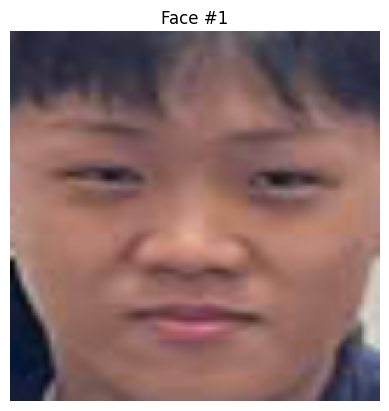

KeyboardInterrupt: Interrupted by user

In [ ]:
from mtcnn import MTCNN
import cv2
import os
import matplotlib.pyplot as plt

# Đường dẫn ảnh nhóm
image_path = '/content/anh nhom.jpg'
output_dir = '/content/data_faces'
os.makedirs(output_dir, exist_ok=True)

# Đọc ảnh & phát hiện khuôn mặt
img = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
detector = MTCNN()
faces = detector.detect_faces(img)

# Vẽ và lưu khuôn mặt
for i, face in enumerate(faces):
    x, y, w, h = face['box']
    x, y = max(0, x), max(0, y)
    face_crop = img[y:y+h, x:x+w]
    face_crop = cv2.resize(face_crop, (160, 160))

    # Hiển thị khuôn mặt
    plt.imshow(face_crop)
    plt.axis('off')
    plt.title(f'Face #{i+1}')
    plt.show()

    # Gán tên thủ công
    name = input(f" Nhập tên cho khuôn mặt #{i+1} (vd: nhan, quan...): ").strip().lower()
    save_path = os.path.join(output_dir, f"{name}.jpg")

    if os.path.exists(save_path):
        print(f" Đã tồn tại: {save_path}, bỏ qua...")
        continue

    cv2.imwrite(save_path, cv2.cvtColor(face_crop, cv2.COLOR_RGB2BGR))
    print(f"✅ Đã lưu vào {save_path}")
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import numpy as np
from glob import glob

# Load data từ thư mục /content/data_faces
def load_data(data_dir):
    X, y = [], []
    label_map = {}
    i = 0
    for img_path in glob(f"{data_dir}/*.jpg"):
        label = os.path.basename(img_path).split('.')[0]
        if label not in label_map:
            label_map[label] = i
            i += 1
        img = cv2.resize(cv2.imread(img_path), (160, 160))
        X.append(img / 255.0)
        y.append(label_map[label])
    return np.array(X), np.array(y), label_map

X, y, label_map = load_data('/content/data_faces')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# CNN Model
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(160,160,3)),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(label_map), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))
def predict_face(image_path):
    img = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    faces = detector.detect_faces(img)
    for face in faces:
        x, y, w, h = face['box']
        x, y = max(0, x), max(0, y)
        face_crop = img[y:y+h, x:x+w]
        face_crop = cv2.resize(face_crop, (160, 160))
        face_norm = face_crop / 255.0
        face_input = np.expand_dims(face_norm, axis=0)

        pred = model.predict(face_input)[0]
        label_idx = np.argmax(pred)
        label_name = [k for k, v in label_map.items() if v == label_idx][0]

        print(f"🔍 Dự đoán: {label_name} ({round(pred[label_idx]*100, 2)}%)")

        # Vẽ kết quả
        plt.imshow(face_crop)
        plt.title(f"Predicted: {label_name}")
        plt.axis('off')
        plt.show()

# Ví dụ dùng
predict_face('/content/data/quan.jpg')  # ảnh mới của một người trong nhóm


In [ ]:
# 1. Import thư viện
from mtcnn import MTCNN
import cv2
import os
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# 2. Tạo thư mục lưu khuôn mặt
output_dir = "/content/data"
os.makedirs(output_dir, exist_ok=True)

# 3. Cắt và lưu khuôn mặt từ ảnh nhóm
filename = "/content/anh nhom.jpg"
image = cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB)
detector = MTCNN()
faces = detector.detect_faces(image)

# Danh sách tên cố định theo thứ tự khuôn mặt
names = ['nhan', 'trieu', 'quan', 'lamanh', 'tuan']

for i, face in enumerate(faces):
    if i >= len(names):
        break  # Dừng nếu số mặt nhiều hơn số tên

    name = names[i]
    save_path = os.path.join(output_dir, f"{name}.jpg")

    if os.path.exists(save_path):
        continue  # Không lưu lại nếu đã tồn tại

    x, y, w, h = face['box']
    x, y = max(0, x), max(0, y)
    face_crop = image[y:y+h, x:x+w]
    face_crop = cv2.resize(face_crop, (160, 160))
    cv2.imwrite(save_path, cv2.cvtColor(face_crop, cv2.COLOR_RGB2BGR))

# 4. Load dữ liệu khuôn mặt
X, y, label_map = [], [], {}
for i, filename in enumerate(os.listdir(output_dir)):
    if filename.endswith(".jpg"):
        path = os.path.join(output_dir, filename)
        img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
        img = img.astype('float32') / 255.0
        X.append(img)

        name = filename.split(".")[0]
        if name not in label_map:
            label_map[name] = len(label_map)
        y.append(label_map[name])

X = np.array(X)
y = np.array(y)

# 5. Chia tập train/test
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = to_categorical(y_train, num_classes=len(label_map))
y_test = to_categorical(y_test, num_classes=len(label_map))

# 6. Tạo mô hình CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(160, 160, 3)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(len(label_map), activation='softmax'),
    Dropout(0.25)
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=100, validation_data=(x_test, y_test))
model.evaluate(x_test, y_test)

# 7. Dự đoán ảnh khuôn mặt mới
# 7. Dự đoán và in khuôn mặt từ ảnh mới
import matplotlib.pyplot as plt

test_img_path = "/content/quan.jpg"
img = cv2.cvtColor(cv2.imread(test_img_path), cv2.COLOR_BGR2RGB)
faces = detector.detect_faces(img)

for i, face in enumerate(faces):
    x, y, w, h = face['box']
    x, y = max(0, x), max(0, y)
    face_crop = img[y:y+h, x:x+w]
    resized_face = cv2.resize(face_crop, (160, 160))

    # Chuẩn hóa và reshape cho mô hình
    face_input = resized_face.astype('float32') / 255.0
    face_input = np.expand_dims(face_input, axis=0)

    # Dự đoán
    prediction = model.predict(face_input)
    predicted_label = np.argmax(prediction)
    predicted_name = list(label_map.keys())[list(label_map.values()).index(predicted_label)]

    # In kết quả
    plt.imshow(resized_face)
    plt.axis('off')
    plt.title(f" Du doan: {predicted_name}")
    plt.show()


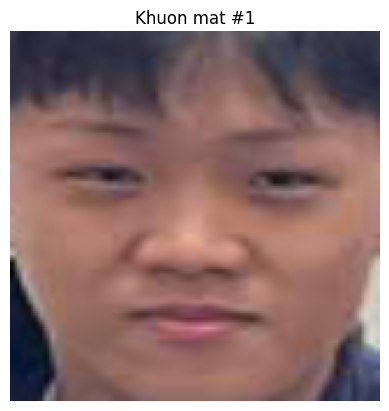

KeyboardInterrupt: Interrupted by user

In [ ]:
# 1. Import thư viện
from mtcnn import MTCNN
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# 2. Tạo thư mục lưu khuôn mặt
output_dir = "/content/data"
os.makedirs(output_dir, exist_ok=True)

# 3. Cắt và lưu khuôn mặt từ ảnh nhóm
filename = "/content/anh nhom.jpg"
image = cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB)
detector = MTCNN()
faces = detector.detect_faces(image)

for i, face in enumerate(faces):
    x, y, w, h = face['box']
    x, y = max(0, x), max(0, y)
    face_crop = image[y:y+h, x:x+w]
    face_crop = cv2.resize(face_crop, (160, 160))

    plt.imshow(face_crop)
    plt.axis('off')
    plt.title(f"Khuon mat #{i+1}")
    plt.show()

    name = input(f"✨ Nhap ten cho khuon mat #{i+1} (VD: lamanh): ").strip().lower().replace(" ", "_")
    save_path = os.path.join(output_dir, f"{name}.jpg")

    if os.path.exists(save_path):
        print(f"⚠️ File {save_path} da ton tai, bo qua")
        continue

    cv2.imwrite(save_path, cv2.cvtColor(face_crop, cv2.COLOR_RGB2BGR))
    print(f"✅ Da luu khuon mat: {save_path}")

# 4. Load dữ liệu khuôn mặt
X = []
y = []
label_map = {}
for i, filename in enumerate(os.listdir(output_dir)):
    if filename.endswith(".jpg"):
        path = os.path.join(output_dir, filename)
        img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
        img = img.astype('float32') / 255.0
        X.append(img)
        name = filename.split(".")[0]
        if name not in label_map:
            label_map[name] = len(label_map)
        y.append(label_map[name])

X = np.array(X)
y = np.array(y)

# 5. Chia tập train/test
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = to_categorical(y_train, num_classes=len(label_map))
y_test = to_categorical(y_test, num_classes=len(label_map))

# 6. Tạo mô hình CNN
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(160, 160, 3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(len(label_map), activation='softmax'))
model.add(Dropout(0.25))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))
model.evaluate(x_test, y_test)

# 7. Dự đoán ảnh khuôn mặt mới
# Tải ảnh mới
test_img_path = "/content/quan.jpg"  # Thay bằng ảnh bạn muốn test
img = cv2.cvtColor(cv2.imread(test_img_path), cv2.COLOR_BGR2RGB)
faces = detector.detect_faces(img)

for i, face in enumerate(faces):
    x, y, w, h = face['box']
    x, y = max(0, x), max(0, y)
    face_crop = img[y:y+h, x:x+w]
    face_crop = cv2.resize(face_crop, (160, 160))
    face_crop = face_crop.astype('float32') / 255.0
    face_crop = np.expand_dims(face_crop, axis=0)

    prediction = model.predict(face_crop)
    predicted_label = np.argmax(prediction)
    predicted_name = list(label_map.keys())[list(label_map.values()).index(predicted_label)]

    print(f"📸 Khuon mat #{i+1} trong anh test du doan la: {predicted_name}")


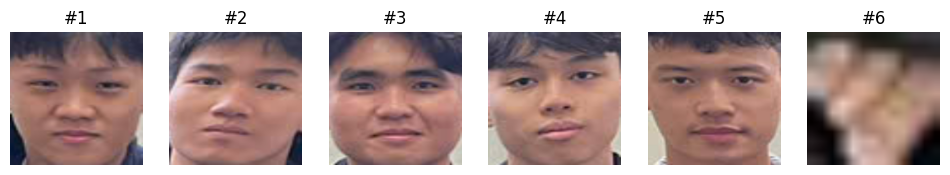

KeyboardInterrupt: Interrupted by user

In [ ]:
# 1. Import thu vien
from mtcnn import MTCNN
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# 2. Tao thu muc luu khuon mat
output_dir = "/content/data"
os.makedirs(output_dir, exist_ok=True)

# 3. Cat va luu khuon mat tu anh nhom
filename = "/content/anh nhom.jpg"
image = cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB)
detector = MTCNN()
faces = detector.detect_faces(image)

# Hien tat ca khuon mat truoc khi gan ten
plt.figure(figsize=(12, 6))
for i, face in enumerate(faces):
    x, y, w, h = face['box']
    x, y = max(0, x), max(0, y)
    face_crop = image[y:y+h, x:x+w]
    face_crop = cv2.resize(face_crop, (160, 160))
    plt.subplot(1, len(faces), i+1)
    plt.imshow(face_crop)
    plt.title(f'#{i+1}')
    plt.axis('off')
plt.show()

# Nhap ten theo thu tu khuon mat
names = input("👉 Nhap ten cho cac khuon mat theo thu tu, cach nhau boi dau phay (VD: lamanh,trieu,quan,nhan,tuan): ")
names = [n.strip().lower().replace(" ", "_") for n in names.split(",")]

# Luu khuon mat voi ten tuong ung
for i, face in enumerate(faces):
    if i >= len(names):
        break
    name = names[i]
    x, y, w, h = face['box']
    x, y = max(0, x), max(0, y)
    face_crop = image[y:y+h, x:x+w]
    face_crop = cv2.resize(face_crop, (160, 160))
    save_path = os.path.join(output_dir, f"{name}.jpg")
    if os.path.exists(save_path):
        print(f"⚠️ File {save_path} da ton tai, bo qua")
        continue
    cv2.imwrite(save_path, cv2.cvtColor(face_crop, cv2.COLOR_RGB2BGR))
    print(f"✅ Da luu khuon mat: {save_path}")

# 4. Load du lieu khuon mat
X = []
y = []
label_map = {}
for i, filename in enumerate(os.listdir(output_dir)):
    if filename.endswith(".jpg"):
        path = os.path.join(output_dir, filename)
        img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
        img = img.astype('float32') / 255.0
        X.append(img)
        name = filename.split(".")[0]
        if name not in label_map:
            label_map[name] = len(label_map)
        y.append(label_map[name])

X = np.array(X)
y = np.array(y)

# 5. Chia tap train/test
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = to_categorical(y_train, num_classes=len(label_map))
y_test = to_categorical(y_test, num_classes=len(label_map))

# 6. Tao mo hinh CNN\model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(160, 160, 3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(len(label_map), activation='softmax'))
model.add(Dropout(0.25))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))
model.evaluate(x_test, y_test)

# 7. Du doan anh khuon mat moi
test_img_path = "/content/quan.jpg"  # Anh test
img = cv2.cvtColor(cv2.imread(test_img_path), cv2.COLOR_BGR2RGB)
faces = detector.detect_faces(img)

for i, face in enumerate(faces):
    x, y, w, h = face['box']
    x, y = max(0, x), max(0, y)
    face_crop = img[y:y+h, x:x+w]
    face_crop = cv2.resize(face_crop, (160, 160))
    face_crop = face_crop.astype('float32') / 255.0
    face_crop = np.expand_dims(face_crop, axis=0)

    prediction = model.predict(face_crop)
    predicted_label = np.argmax(prediction)
    predicted_name = list(label_map.keys())[list(label_map.values()).index(predicted_label)]
 # In kết quả
    plt.imshow(resized_face)
    plt.axis('off')
    plt.title(f"💡 Du doan: {predicted_name}")
    plt.show()


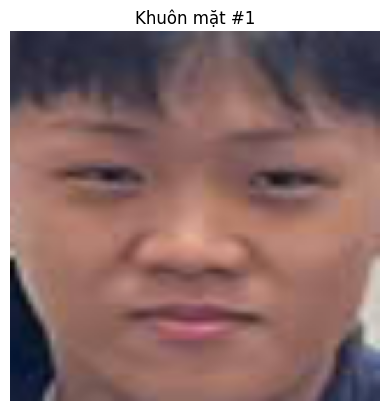

✅ Đã lưu khuôn mặt: /content/data/face_1.jpg


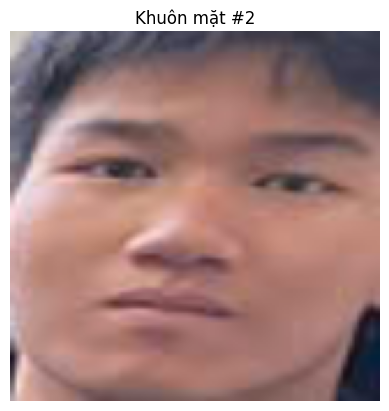

✅ Đã lưu khuôn mặt: /content/data/face_2.jpg


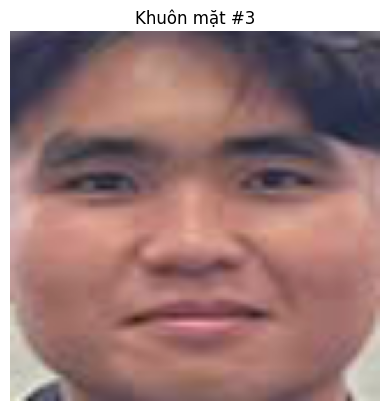

✅ Đã lưu khuôn mặt: /content/data/face_3.jpg


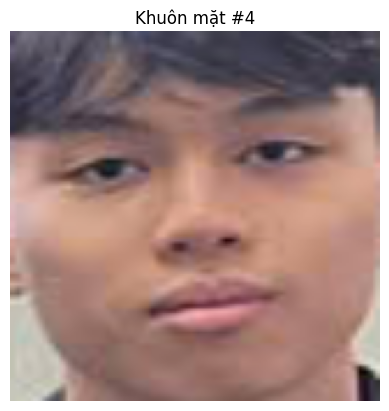

✅ Đã lưu khuôn mặt: /content/data/face_4.jpg


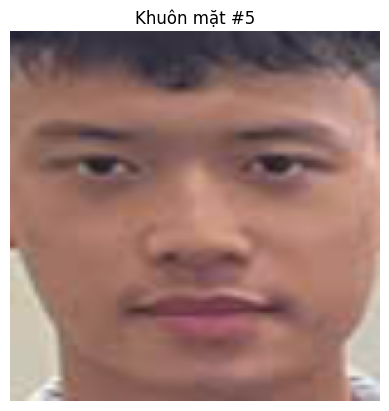

⚠️ File /content/data/face_5.jpg đã tồn tại, bỏ qua


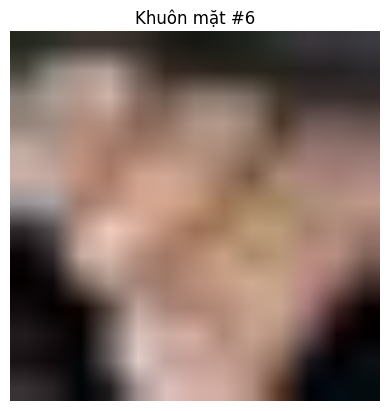

⚠️ File /content/data/face_6.jpg đã tồn tại, bỏ qua
Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.1250 - loss: 3.8602 - val_accuracy: 0.0000e+00 - val_loss: 5.0362
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.0000e+00 - loss: 6.0050 - val_accuracy: 0.0000e+00 - val_loss: 4.1107
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 957ms/step - accuracy: 0.1250 - loss: 5.7039 - val_accuracy: 0.0000e+00 - val_loss: 3.3953
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 981ms/step - accuracy: 0.3750 - loss: 5.2512 - val_accuracy: 0.0000e+00 - val_loss: 3.3207
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 941ms/step - accuracy: 0.1250 - loss: 7.2082 - val_accuracy: 0.0000e+00 - val_loss: 3.6144
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 949ms/step - accuracy: 0.2500 - loss: 3.6610 - val_accuracy: 0.0000e+00 - val_loss: 3.4813
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.1250 - loss: 2.0038 - val_accuracy: 0.0000e+00 - val_loss: 3.1818
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 964m

In [ ]:
# 1. Import thư viện
from mtcnn import MTCNN
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# 2. Tạo thư mục lưu khuôn mặt
output_dir = "/content/data"
os.makedirs(output_dir, exist_ok=True)

# 3. Cắt và lưu khuôn mặt từ ảnh nhóm
filename = "/content/anh nhom.jpg"
image = cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB)
detector = MTCNN()
faces = detector.detect_faces(image)

for i, face in enumerate(faces):
    x, y, w, h = face['box']
    x, y = max(0, x), max(0, y)
    face_crop = image[y:y+h, x:x+w]
    face_crop = cv2.resize(face_crop, (160, 160))

    plt.imshow(face_crop)
    plt.axis('off')
    plt.title(f"Khuôn mặt #{i+1}")
    plt.show()

    name = f"face_{i+1}"
    save_path = os.path.join(output_dir, f"{name}.jpg")

    if os.path.exists(save_path):
        print(f"⚠️ File {save_path} đã tồn tại, bỏ qua")
        continue

    cv2.imwrite(save_path, cv2.cvtColor(face_crop, cv2.COLOR_RGB2BGR))
    print(f"✅ Đã lưu khuôn mặt: {save_path}")

# 4. Load dữ liệu khuôn mặt
X, y = [], []
label_map = {}
for filename in os.listdir(output_dir):
    if filename.endswith(".jpg"):
        path = os.path.join(output_dir, filename)
        img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
        img = img.astype('float32') / 255.0
        X.append(img)
        name = filename.split(".")[0]
        if name not in label_map:
            label_map[name] = len(label_map)
        y.append(label_map[name])

X = np.array(X)
y = np.array(y)

# 5. Chia tập train/test
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = to_categorical(y_train, num_classes=len(label_map))
y_test = to_categorical(y_test, num_classes=len(label_map))

# 6. Tạo mô hình CNN
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(160, 160, 3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(len(label_map), activation='softmax'))
model.add(Dropout(0.25))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))
model.evaluate(x_test, y_test)

# 7. Dự đoán ảnh khuôn mặt mới
test_img_path = "/content/quan.jpg"  # Thay bằng ảnh bạn muốn test
img = cv2.cvtColor(cv2.imread(test_img_path), cv2.COLOR_BGR2RGB)
faces = detector.detect_faces(img)

for i, face in enumerate(faces):
    x, y, w, h = face['box']
    x, y = max(0, x), max(0, y)
    face_crop = img[y:y+h, x:x+w]
    face_crop = cv2.resize(face_crop, (160, 160))
    face_crop = face_crop.astype('float32') / 255.0
    face_crop = np.expand_dims(face_crop, axis=0)

    prediction = model.predict(face_crop)
    predicted_label = np.argmax(prediction)
    predicted_name = list(label_map.keys())[list(label_map.values()).index(predicted_label)]

    print(f"📸 Khuôn mặt #{i+1} trong ảnh test được dự đoán là: {predicted_name}")


In [ ]:
# 1. Import thư viện
from mtcnn import MTCNN
import cv2
import os
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# 2. Tạo thư mục lưu khuôn mặt
output_dir = "/content/data"
os.makedirs(output_dir, exist_ok=True)

# 3. Cắt và lưu khuôn mặt từ ảnh nhóm (không in, không hỏi, ghi đè)
filename = "/content/anh nhom.jpg"
image = cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB)
detector = MTCNN()
faces = detector.detect_faces(image)

for i, face in enumerate(faces):
    x, y, w, h = face['box']
    x, y = max(0, x), max(0, y)
    face_crop = image[y:y+h, x:x+w]
    face_crop = cv2.resize(face_crop, (160, 160))

    name = f"face_{i+1}"
    save_path = os.path.join(output_dir, f"{name}.jpg")

    # 🟢 Ghi đè nếu file đã tồn tại
    cv2.imwrite(save_path, cv2.cvtColor(face_crop, cv2.COLOR_RGB2BGR))

# 4. Load dữ liệu khuôn mặt
X, y = [], []
label_map = {}
for filename in os.listdir(output_dir):
    if filename.endswith(".jpg"):
        path = os.path.join(output_dir, filename)
        img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
        img = img.astype('float32') / 255.0
        X.append(img)
        name = filename.split(".")[0]
        if name not in label_map:
            label_map[name] = len(label_map)
        y.append(label_map[name])

X = np.array(X)
y = np.array(y)

# 5. Chia tập train/test
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = to_categorical(y_train, num_classes=len(label_map))
y_test = to_categorical(y_test, num_classes=len(label_map))

# 6. Tạo mô hình CNN
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(160, 160, 3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(len(label_map), activation='softmax'))
model.add(Dropout(0.25))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=100, validation_data=(x_test, y_test))
model.evaluate(x_test, y_test)

# 7. Dự đoán ảnh khuôn mặt mới
test_img_path = "/content/quan.jpg"  # Thay bằng ảnh bạn muốn test
img = cv2.cvtColor(cv2.imread(test_img_path), cv2.COLOR_BGR2RGB)
faces = detector.detect_faces(img)

for i, face in enumerate(faces):
    x, y, w, h = face['box']
    x, y = max(0, x), max(0, y)
    face_crop = img[y:y+h, x:x+w]
    face_crop = cv2.resize(face_crop, (160, 160))
    face_crop = face_crop.astype('float32') / 255.0
    face_crop = np.expand_dims(face_crop, axis=0)

    prediction = model.predict(face_crop)
    predicted_label = np.argmax(prediction)
    predicted_name = list(label_map.keys())[list(label_map.values()).index(predicted_label)]

    print(f"📸 Khuôn mặt #{i+1} trong ảnh test được dự đoán là: {predicted_name}")


Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.1000 - loss: 6.4771 - val_accuracy: 0.0000e+00 - val_loss: 5.1877
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.1000 - loss: 8.7719 - val_accuracy: 0.0000e+00 - val_loss: 4.4668
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.1000 - loss: 6.5411 - val_accuracy: 0.0000e+00 - val_loss: 3.6701
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.2000 - loss: 6.3839 - val_accuracy: 0.0000e+00 - val_loss: 3.2500
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.1000 - loss: 6.5023 - val_accuracy: 0.0000e+00 - val_loss: 2.9741
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.2000 - loss: 4.9257 - val_accuracy: 0.0000e+00 - val_loss: 2.9821
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3000 - loss: 3.5042

KeyboardInterrupt: 

In [ ]:
pip install mtcnn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 58.4 MB/s eta 0:00:00
